In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import netCDF4
from difflib import SequenceMatcher
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
def OLSE_NORM(X,Y,add_intercept=True):
    
    ## computes a multiple OLS regression over a field against several indices. First dimension is time, second is features (X), or targets (Y)
    
    if add_intercept:
    
        X_1 = np.concatenate((np.ones(X.shape[0])[:,np.newaxis],X),axis=1)
        
    else:
        
        X_1 = X.copy()
    
    B = np.dot( np.linalg.inv( np.dot( X_1.T , X_1 ) ) , np.dot( X_1.T , Y ) )
    
    e = Y - np.dot(X_1,B)
    
    SSE = np.sum(e**2,axis=0)

    MSE_var = SSE / (X_1.shape[0] - X_1.shape[-1])

    SE_B = np.sqrt( np.diag( np.linalg.inv( np.dot( X_1.T , X_1 ) ) )[:,np.newaxis] * MSE_var[np.newaxis,:] )
    
    return {'coefs':B[1:],'coef_err':SE_B[1:],'res':e,'intercept':B[0],'intercept_err':SE_B[0]}

## Emissions -> concentrations

### CO2

In [3]:
RCMIP_concs = pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/protocol/rcmip-concentrations-annual-means-v4-0-0.csv')
RCMIP_emms = pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/protocol/rcmip-emissions-annual-means-v4-0-0.csv')
RCMIP_forc = pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/protocol/rcmip-radiative-forcing-annual-means-v4-0-0.csv')

In [4]:
RCMIP_emms.loc[RCMIP_emms.Mip_Era=='CMIP6'].Scenario.unique()

array(['ssp370', 'ssp370-lowNTCF-aerchemmip', 'ssp370-lowNTCF-gidden',
       'historical', 'ssp434', 'ssp460', 'ssp119', 'ssp126', 'ssp245',
       'ssp534-over', 'ssp585', 'esm-bell-1000PgC', 'esm-bell-2000PgC',
       'esm-bell-750PgC', 'esm-pi-CO2pulse', 'esm-pi-cdr-pulse',
       'esm-piControl'], dtype=object)

In [5]:
# pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/fair/rcmip_phase-1_fair-1.5-default-1pctCO2-4xext_v1-0-1.csv')

cicero_scm = pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/cicero-scm/rcmip_phase-1_cicero-scm_v5-0-0.csv')
cicero_scm.iloc[:,6:] = cicero_scm.iloc[:,6:].apply(pd.to_numeric)
cicero_scm.columns = list(cicero_scm.columns)[:6] + [int(x) for x in list(cicero_scm.columns)[6:]]

fair_scm = pd.concat([pd.read_csv(x) for x in glob.glob('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/fair/*default*v1-0-1*')])
fair_scm.columns = [str(x) for x in np.arange(1850,2501)]+list(fair_scm.columns[-6:])
fair_scm = fair_scm.loc[:,list(fair_scm.columns[-6:])+[str(x) for x in np.arange(1850,2501)]]
fair_scm.iloc[:,6:] = fair_scm.iloc[:,6:].apply(pd.to_numeric)
fair_scm.columns = list(fair_scm.columns)[:6] + [int(x) for x in list(fair_scm.columns)[6:]]

magicc_scm = pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/magicc7/rcmip_phase-1_magicc7.1.0.beta_v1-0-0.csv')
magicc_scm.iloc[:,6:] = magicc_scm.iloc[:,6:].apply(pd.to_numeric)
magicc_scm.columns = list(magicc_scm.columns)[:6] + [int(x) for x in list(magicc_scm.columns)[6:]]

ar5ir_scm = pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/ar5ir/ar5ir-phase-1-results-v2-0-0.csv')
ar5ir_scm = ar5ir_scm.loc[ar5ir_scm.Climatemodel=='ar5ir2box-ECS-3K']
ar5ir_scm.iloc[:,6:] = ar5ir_scm.iloc[:,6:].apply(pd.to_numeric)
ar5ir_scm.columns = list(ar5ir_scm.columns)[:6] + [int(x) for x in list(ar5ir_scm.columns)[6:]]

hector_scm = pd.read_excel('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/hector/rcmip_phase-1_hector_v2-0-0.xlsx','your_data')

greb_scm = pd.read_excel('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/greb/rcmip_phase-1_greb_v2-0-0.xlsx','your_data')

escimo_scm = pd.read_excel('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/escimo/escimo-phase-1-v2-0-1.xlsx','your_data')

oscar_scm = pd.concat([pd.read_excel(x,'your_data') for x in glob.glob('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/oscar/*v1-0-1*')])

mce_scm = pd.concat([pd.read_excel(x,'your_data') for x in glob.glob('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/mce/*v3-0-0*')])

wasp_scm = pd.concat([pd.read_excel(x,'your_data') for x in glob.glob('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/wasp/*v1-0-2*')])

gir_scm = pd.concat([pd.read_csv(x) for x in glob.glob('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/gir/*v1-0-0*.csv')])
gir_scm.iloc[:,6:] = gir_scm.iloc[:,6:].apply(pd.to_numeric)
gir_scm.columns = list(gir_scm.columns)[:6] + [int(x) for x in list(gir_scm.columns)[6:]]

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [6]:
oscar_scm.Scenario.unique()

array(['esm-ssp585-ssp126Lu', 'esm-yr2010CO2-cdr-pulse',
       'esm-yr2010CO2-CO2pulse', 'esm-yr2010CO2-noemit', 'hist-CO2',
       'hist-GHG', 'hist-aer', 'hist-bgc', 'hist-nat', 'hist-sol',
       'hist-stratO3', 'hist-volc', 'historical', 'historical-cmip5',
       'piControl', 'rcp26', 'rcp45', 'rcp60', 'rcp85', 'ssp119',
       'ssp126', 'ssp245', 'ssp245-GHG', 'ssp245-aer', 'ssp245-nat',
       'ssp245-stratO3', 'ssp370', 'ssp370-lowNTCF-aerchemmip',
       'ssp370-lowNTCF-gidden', 'ssp434', 'ssp460', 'ssp534-over',
       'ssp534-over-bgc', 'ssp585', 'ssp585-bgc', '1pctCO2',
       '1pctCO2-4xext', '1pctCO2-cdr', '1pctCO2-bgc', '1pctCO2-rad',
       'abrupt-0p5xCO2', 'abrupt-2xCO2', 'abrupt-4xCO2',
       'esm-1pct-brch-1000PgC', 'esm-1pct-brch-2000PgC',
       'esm-1pct-brch-750PgC', 'esm-1pctCO2', 'esm-bell-1000PgC',
       'esm-bell-2000PgC', 'esm-bell-750PgC', 'esm-hist',
       'esm-hist-cmip5', 'esm-pi-CO2pulse', 'esm-pi-cdr-pulse',
       'esm-piControl', 'esm-rcp26', 'e

In [7]:
cicero_scm.Variable.unique()

array(['Atmospheric Concentrations|CH4', 'Atmospheric Concentrations|CO2',
       'Atmospheric Concentrations|F-Gases|HFC|HFC125',
       'Atmospheric Concentrations|F-Gases|HFC|HFC134a',
       'Atmospheric Concentrations|F-Gases|HFC|HFC143a',
       'Atmospheric Concentrations|F-Gases|HFC|HFC227ea',
       'Atmospheric Concentrations|F-Gases|HFC|HFC23',
       'Atmospheric Concentrations|F-Gases|HFC|HFC245fa',
       'Atmospheric Concentrations|F-Gases|HFC|HFC32',
       'Atmospheric Concentrations|F-Gases|HFC|HFC4310mee',
       'Atmospheric Concentrations|F-Gases|PFC|C2F6',
       'Atmospheric Concentrations|F-Gases|PFC|C6F14',
       'Atmospheric Concentrations|F-Gases|PFC|CF4',
       'Atmospheric Concentrations|F-Gases|SF6',
       'Atmospheric Concentrations|Montreal Gases|CCl4',
       'Atmospheric Concentrations|Montreal Gases|CFC|CFC11',
       'Atmospheric Concentrations|Montreal Gases|CFC|CFC113',
       'Atmospheric Concentrations|Montreal Gases|CFC|CFC114',
       'Atmos

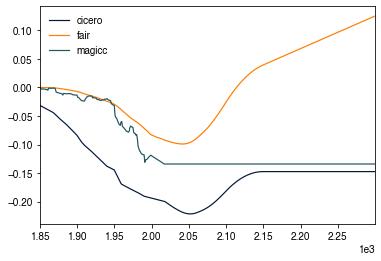

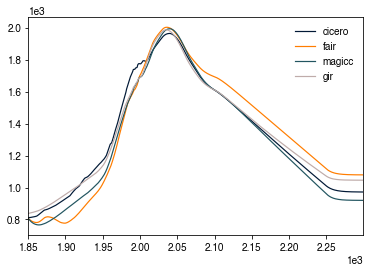

In [425]:
labels = ['cicero','fair','magicc','ar5ir','hector','greb','escimo','oscar','mce','wasp','gir']
scenario = 'esm-ssp245-allGHG'
variable = 'Effective Radiative Forcing|Anthropogenic|Albedo Change'
fig,ax = plt.subplots()
[x.loc[(x.Scenario==scenario)&(x.Variable==variable)].iloc[0,6:].loc[range(1850,2300)].rename(labels[i]).plot(ax=ax,lw=1.2) for i,x in enumerate([cicero_scm,fair_scm,magicc_scm,ar5ir_scm,hector_scm,greb_scm,escimo_scm,oscar_scm,mce_scm,wasp_scm,gir_scm]) if (scenario in x.Scenario.unique()) and (variable in x.Variable.unique())]
plt.legend()
# scenario = 'esm-ssp119-allGHG'
variable = 'Atmospheric Concentrations|CH4'
fig,ax = plt.subplots()
[x.loc[(x.Scenario==scenario)&(x.Variable==variable)].iloc[0,6:].loc[range(1850,2300)].rename(labels[i]).plot(ax=ax,lw=1.2) for i,x in enumerate([cicero_scm,fair_scm,magicc_scm,ar5ir_scm,hector_scm,greb_scm,escimo_scm,oscar_scm,mce_scm,wasp_scm,gir_scm]) if (scenario in x.Scenario.unique()) and (variable in x.Variable.unique())]
plt.legend()

In [9]:
## write up a basic version of GIR for CO2 only to start

In [10]:
RCP_data = {}
RCP_data['RF'] = {}
RCP_data['C'] = {}
RCP_data['E'] = {}

for RCP in ['3PD','45','6','85']:
    RCP_data['C'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_MIDYEAR_CONCENTRATIONS.csv',skiprows=37,index_col=0).loc[np.arange(1765,2201)]
    RCP_data['RF'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0).loc[np.arange(1765,2201)]
    RCP_data['E'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_EMISSIONS.csv',skiprows=36,index_col=0).loc[:2200]
    RCP_data['E'][RCP]['CO2'] = RCP_data['E'][RCP][['FossilCO2','OtherCO2']].sum(axis=1)

In [11]:
## use to calculate q/d values
tcr_ecs_to_q(pd.DataFrame(data=np.array([[4.1,239],[1.75,3]]),index=['d','tcr_ecs'],columns=[np.array(['default']*2),np.array([1,2])]))

default            
          1           2
d  4.100000  239.000000
q  0.435136    0.346114

In [12]:
param_dict = {'a':np.array([[0.2173,0.224,0.2824,0.2763]]),
             'tau':np.array([[1e6,394.4,36.54,4.304]]),
             'r':np.array([[28.627,0.019773,4.334433,0]]),
             'emis2conc':0.468952,
             'PI_conc':278,
             'f':np.array([5.7544,0.001215,-0.069598]),
             'd':np.array([[4.1,239]]),
             'q':np.array([[0.435,0.346]])}

def calculate_alpha_1(G,G_A,T,r,g0,g1,iirf100_max = 97.0):

	alpha_val = r[...,0] * (1+G-G_A) ** r[...,1] * (1+T) ** r[...,2] * G_A ** r[...,3]

	return alpha_val

def GIR_bones(emissions,other_rf,param_dict,alpha_calc=calculate_alpha):
    
    a = param_dict['a']
    tau = param_dict['tau']
    r = param_dict['r']
    emis2conc = param_dict['emis2conc']
    PI_conc = param_dict['PI_conc']
    f = param_dict['f']
    d = param_dict['d']
    q = param_dict['q']
    
    g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
    g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) )**(-1.)
    
    C = np.empty(emissions.size)
    RF = np.empty(emissions.size)
    T = np.empty(emissions.size)
    alpha = np.empty(emissions.size)
    G = np.cumsum(emissions)
    
    alpha[0] = alpha_calc(0,0,0,r,g0,g1)
    C[0],R,G_A = step_concentration(R_old = np.zeros(a.shape),alpha=alpha[0],E=emissions[0],a=a,tau=tau,PI_conc=PI_conc,emis2conc=np.array([emis2conc]))
    RF[0] = step_forcing(C=C[0],PI_conc=PI_conc,f=f)
    S,T[0] = step_temperature(S_old=np.zeros(d.shape),F=RF[0]+other_rf[0],q=q,d=d)
    
    for t in np.arange(1,emissions.size):
        alpha[t] = alpha_calc(G=G[t-1],G_A=G_A,T=np.sum(S),r=r,g0=g0,g1=g1)
        C[t],R,G_A = step_concentration(R_old = R,alpha=alpha[t],E=emissions[t],a=a,tau=tau,PI_conc=PI_conc,emis2conc=np.array([emis2conc]))
        RF[t] = step_forcing(C=C[t],PI_conc=PI_conc,f=f)
        S,T[t] = step_temperature(S_old=S,F=RF[t]+other_rf[t],q=q,d=d)
        
    return pd.DataFrame(dict(zip(['alpha','C','RF','T'],[alpha,C,RF,T])))

## Separating RF components

In [114]:
emissions_in.loc[:,'ems_b'].shape

(736, 3)

In [380]:
emissions_in = False
concentrations_in = False
forcing_in = False
gas_parameters = get_gas_parameter_defaults()
thermal_parameters = get_thermal_parameter_defaults()
show_run_info = True

# concentrations_in = return_empty_emissions(scen_names=['default'])
# concentrations_in.loc[:] = np.array(list(gas_parameters.loc['PI_conc']))
# concentrations_in.loc[1800]+=100

emissions_in = return_empty_emissions(scen_names=['ems_a','ems_b'])
emissions_in.loc[1800,'ems_a'] = 100
emissions_in.loc[:,'ems_b'] = np.array([np.exp(0.001*np.arange(1,emissions_in.index.size+1))]*3).T

gas_parameters = get_gas_parameter_defaults()#['default']
gas_parameters.loc[['f1','f2','f3'],('default','CH4|Trop_Ozone')] = [0,0.000182,0]
# gas_parameters = pd.concat([gas_parameters]*2,axis=1,keys=['gas_a','gas_b'])
# # gas_parameters.loc[['f1','f2','f3'],('gas_a','CH4|Trop_Ozone')] = [0,0.000182,0]
# gas_parameters.loc[['f1','f2','f3'],('gas_b','CH4|Trop_Ozone')] = [0,0,0]

thermal_parameters = tcr_ecs_to_q(pd.DataFrame(data=np.array([[4.1,239],[1.75,3]]),index=['d','tcr_ecs'],columns=[np.array(['default']*2),np.array([1,2])]))

## GIR code:

# Determine the number of scenario runs , parameter sets , gases , integration period, timesteps

# There are 2 modes : emissions_driven , concentration_driven

# The model will assume if both are given then emissions take priority

if emissions_in is False: # check if concentration driven
    concentration_driven = True
    emissions_in = return_empty_emissions(concentrations_in,gases_in=concentrations_in.columns.levels[1])
    time_index = concentrations_in.index
else: # otherwise emissions driven
    concentration_driven=False
    time_index = emissions_in.index

[(dim_scenario,scen_names),(dim_gas_param,gas_set_names),(dim_thermal_param,thermal_set_names)]=[(x.size,list(x)) for x in [emissions_in.columns.levels[0],gas_parameters.columns.levels[0],thermal_parameters.columns.levels[0]]]
gas_names = [x for x in gas_parameters.columns.levels[1] if '|' not in x]
n_gas = len(gas_names)
n_forc,forc_names = gas_parameters.columns.levels[1].size,list(gas_parameters.columns.levels[1])
n_year = time_index.size

## map the concentrations onto the forcings 
gas_forc_map = [gas_names.index(forc_names[x].split('|')[0]) for x in np.arange(len(forc_names))]

names_list = [scen_names,gas_set_names,thermal_set_names,gas_names]
names_titles = ['Scenario','Gas cycle set','Thermal set','Gas name']
forc_names_list = [scen_names,gas_set_names,thermal_set_names,forc_names]
forc_names_titles = ['Scenario','Gas cycle set','Thermal set','Forcing component']

timestep = np.append(np.diff(time_index),np.diff(time_index)[-1])

emissions = emissions_in.loc[:,(scen_names,gas_names)].values.T.reshape(dim_scenario,1,1,n_gas,n_year)

# check if no dimensions are degenerate
if (set(scen_names) != set(gas_set_names))&(set(scen_names) != set(thermal_set_names))&(set(gas_set_names) != set(thermal_set_names)):
    gas_shape, gas_slice = [1,dim_gas_param,1],gas_set_names
    therm_shape, therm_slice = [1,1,dim_thermal_param],thermal_set_names
# check if all degenerate
elif (set(scen_names) == set(gas_set_names))&(set(scen_names) == set(thermal_set_names)):
    gas_shape, gas_slice = [dim_scenario,1,1],scen_names
    therm_shape, therm_slice = [dim_scenario,1,1],scen_names
    dim_gas_param = 1
    dim_thermal_param = 1
    [x.pop(1) for x in [names_list,names_titles,forc_names_list,forc_names_titles]]
    [x.pop(1) for x in [names_list,names_titles,forc_names_list,forc_names_titles]]
# check other possibilities
else:
    if set(scen_names) == set(gas_set_names):
        gas_shape, gas_slice = [dim_scenario,1,1],scen_names
        therm_shape, therm_slice = [1,1,dim_thermal_param],thermal_set_names
        dim_gas_param = 1
        [x.pop(1) for x in [names_list,names_titles,forc_names_list,forc_names_titles]]
    elif set(scen_names) == set(thermal_set_names):
        gas_shape, gas_slice = [1,dim_gas_param,1],gas_set_names
        therm_shape, therm_slice = [dim_scenario,1,1],scen_names
        dim_thermal_param = 1
        [x.pop(2) for x in [names_list,names_titles,forc_names_list,forc_names_titles]]
    else:
        gas_shape, gas_slice = [1,dim_gas_param,1],gas_set_names
        therm_shape, therm_slice = [1,dim_gas_param,1],gas_set_names
        dim_thermal_param = 1
        [x.pop(2) for x in [names_list,names_titles,forc_names_list,forc_names_titles]]    

a,tau,r,PI_conc,emis2conc=[gas_parameters.loc[x,(gas_slice,gas_names)].values.T.reshape(gas_shape+[n_gas,-1]) for x in [['a1','a2','a3','a4'],['tau1','tau2','tau3','tau4'],['r0','rC','rT','rA'],'PI_conc','emis2conc']]
f = gas_parameters.loc['f1':'f3',(gas_slice,forc_names)].values.T.reshape(gas_shape+[n_forc,-1])
d,q = [thermal_parameters.loc[[x],(therm_slice,slice(None))].values.T.reshape(therm_shape+[-1]) for x in ['d','q']]

if show_run_info:
    print('Integrating ' + str(dim_scenario) + ' scenarios, ' + str(dim_gas_param) + ' gas cycle parameter sets, ' + str(dim_thermal_param) + ' independent thermal response parameter sets, over ' + str(list(emissions_in.columns.levels[1])) + ', between ' + str(time_index[0]) + ' and ' + str(time_index[-1]) + '...')

if forcing_in is False:
    ext_forcing = np.zeros((dim_scenario,1,1,1,n_year))
else:
    forcing_in = forcing_in.reindex(scen_names,axis=1,level=0)
    ext_forcing = forcing_in.loc[:,(scen_names,slice(None))].values.T.reshape(dim_scenario,1,1,1,n_year)

# Dimensions : [scenario, gas params, thermal params, gas, time, (gas/thermal pools)]

g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) )**(-1.)

# Create appropriate shape variable arrays / calculate RF if concentration driven

C = np.zeros((dim_scenario,dim_gas_param,dim_thermal_param,n_gas,n_year))
RF = np.zeros((dim_scenario,dim_gas_param,dim_thermal_param,n_forc,n_year))
T = np.zeros((dim_scenario,dim_gas_param,dim_thermal_param,n_year))
alpha = np.zeros((dim_scenario,dim_gas_param,dim_thermal_param,n_gas,n_year))
alpha[...,0] = calculate_alpha(G=np.zeros(C[...,0].shape),G_A=np.zeros(C[...,0].shape),T=np.zeros(C[...,0].shape),r=r,g0=g0,g1=g1)

if concentration_driven:

    diagnosed_emissions = np.zeros((dim_scenario,dim_gas_param,dim_thermal_param,n_gas,n_year))
    C[:] = input_to_numpy(concentrations_in.reindex(scen_names,axis=1,level=0).reindex(gas_names,axis=1,level=1))[:,np.newaxis,np.newaxis,...]
    C_end = np.zeros(C.shape)
    RF[:] = step_forcing(C[...,gas_forc_map,:],PI_conc[...,gas_forc_map,:],f[...,np.newaxis,:])
    C_end[...,0] = C[...,0]*2 - PI_conc[...,0]
    diagnosed_emissions[...,0],R,G_A = unstep_concentration(R_old=np.zeros(a.shape),C=C_end[...,0],alpha=alpha[...,0,np.newaxis],a=a,tau=tau,PI_conc=PI_conc[...,0],emis2conc=emis2conc[...,0],dt=timestep[0])
    S,T[...,0] = step_temperature(S_old=np.zeros(d.shape),F=np.sum(RF[...,0],axis=-1)[...,np.newaxis]+ext_forcing[...,0],q=q,d=d,dt=timestep[0])
    for t in np.arange(1,n_year):
        G = np.sum(diagnosed_emissions,axis=-1)
        alpha[...,t] = calculate_alpha(G=G,G_A=G_A,T=np.sum(S,axis=-1)[...,np.newaxis],r=r,g0=g0,g1=g1)
        C_end[...,t] = C[...,t]*2 - C_end[...,t-1]
        diagnosed_emissions[...,t],R,G_A = unstep_concentration(R_old=R,C=C_end[...,t],alpha=alpha[...,t,np.newaxis],a=a,tau=tau,PI_conc=PI_conc[...,0],emis2conc=emis2conc[...,0],dt=timestep[t])
        S,T[...,t] = step_temperature(S_old=S,F=np.sum(RF[...,t],axis=-1)[...,np.newaxis]+ext_forcing[...,t],q=q,d=d,dt=timestep[t])

    C_out = concentrations_in
    E_out = pd.DataFrame(np.moveaxis(diagnosed_emissions,-1,0).reshape(diagnosed_emissions.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list,names=names_titles))

if not concentration_driven:
    G = np.cumsum(emissions,axis=-1)
    C[...,0],R,G_A = step_concentration(R_old = np.zeros(a.shape),alpha=alpha[...,0,np.newaxis],E=emissions[...,0,np.newaxis],a=a,tau=tau,PI_conc=PI_conc[...,0],emis2conc=emis2conc[...,0],dt=timestep[0])
    RF[...,0] = step_forcing(C=C[...,gas_forc_map,0],PI_conc=PI_conc[...,gas_forc_map,0],f=f)
    S,T[...,0] = step_temperature(S_old=np.zeros(d.shape),F=np.sum(RF[...,0],axis=-1)[...,np.newaxis]+ext_forcing[...,0],q=q,d=d,dt=timestep[0])

    for t in np.arange(1,n_year):
        alpha[...,t] = calculate_alpha(G=G[...,t-1],G_A=G_A,T=np.sum(S,axis=-1)[...,np.newaxis],r=r,g0=g0,g1=g1)
        C[...,t],R,G_A = step_concentration(R_old = R,alpha=alpha[...,t,np.newaxis],E=emissions[...,t,np.newaxis],a=a,tau=tau,PI_conc=PI_conc[...,0],emis2conc=emis2conc[...,0],dt=timestep[t])
        RF[...,t] = step_forcing(C=C[...,gas_forc_map,t],PI_conc=PI_conc[...,gas_forc_map,0],f=f)
        S,T[...,t] = step_temperature(S_old=S,F=np.sum(RF[...,t],axis=-1)[...,np.newaxis]+ext_forcing[...,t],q=q,d=d,dt=timestep[t])

    C_out = pd.DataFrame(np.moveaxis(C,-1,0).reshape(C.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list,names=names_titles))
    E_out = emissions_in

ext_forcing = np.zeros(np.sum(RF,axis=-2)[...,np.newaxis,:].shape) + ext_forcing
RF = np.concatenate((RF,ext_forcing),axis=-2)
RF = np.concatenate((RF,np.sum(RF,axis=-2)[...,np.newaxis,:]),axis=-2)

alpha_out = pd.DataFrame(np.moveaxis(alpha,-1,0).reshape(alpha.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list,names=names_titles))
RF_out = pd.DataFrame(np.moveaxis(RF,-1,0).reshape(RF.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product([x+['External','Total']*(x==forc_names_list[-1]) for x in forc_names_list],names=forc_names_titles))
T_out = pd.DataFrame(np.moveaxis(T,-1,0).reshape(T.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list[:-1],names=names_titles[:-1]))

out_dict = {'C':C_out, \
            'RF':RF_out, \
            'T':T_out, \
            'alpha':alpha_out, \
            'Emissions':E_out , \
            'gas_parameters':gas_parameters , \
            'thermal parameters':thermal_parameters}

for axis in [x for x in list(out_dict.keys())[:-2] if type(x)==pd.core.frame.DataFrame]:
    out_dict[axis].index = out_dict[axis].index.rename('Year')

# return out_dict


Integrating 2 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['CH4', 'CO2', 'N2O'], between 1765.0 and 2500.0...


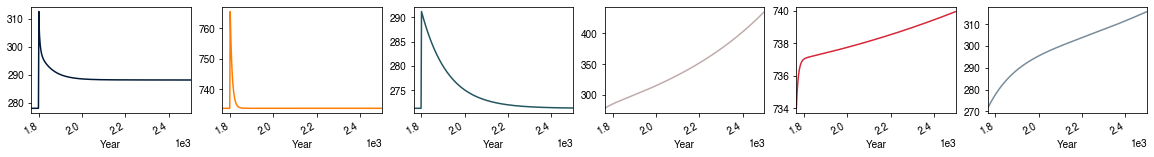

In [381]:
C_plot = out_dict['C'].plot(subplots=True,layout=(4,6),figsize=(20,10),legend=False)

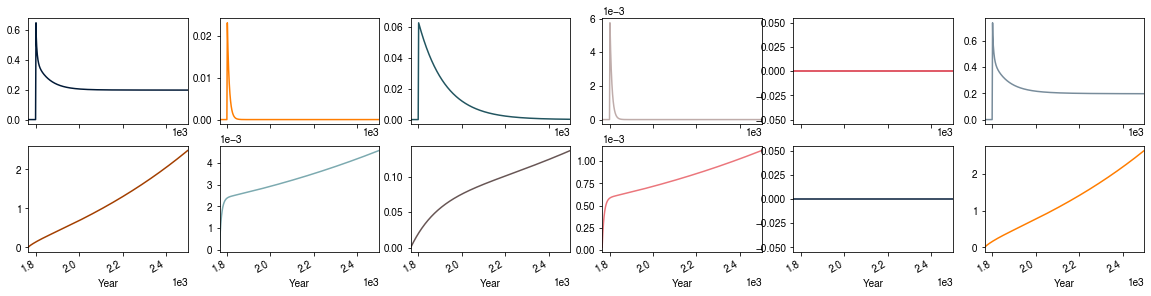

In [382]:
RF_plot = out_dict['RF'].plot(subplots=True,layout=(4,6),figsize=(20,10),legend=False)

## Calculating alpha from emissions and concentrations:

It works well for concentration series from GIR... not so much for other models

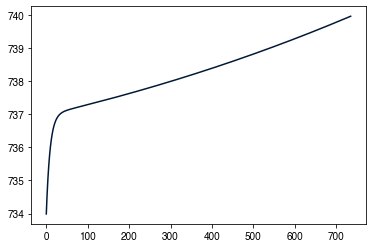

In [417]:
plt.plot(get_alpha_from_E_C(out_dict['C'].loc[:,('ems_b','default','CH4')].values,out_dict['Emissions'].loc[:,('ems_b','CH4')].values,a.squeeze()[1],tau.squeeze()[1],PI_conc.squeeze()[1],emis2conc.squeeze()[1],timestep=False)[1])

## Collecting gas cycle parameters

In [15]:
print(get_gas_parameter_defaults(help=True))

This function returns the GIR default parameter set for a gas set of your choice. You can choose from the following gas species:
['BC', 'C2F6', 'C3F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'CCl4', 'CF4', 'CFC-11', 'CFC-113', 'CFC-114', 'CFC-115', 'CFC-12', 'CH2Cl2', 'CH3Br', 'CH3CCl3', 'CH3Cl', 'CH4', 'CHCl3', 'CO', 'CO2', 'HCFC-141b', 'HCFC-142b', 'HCFC-22', 'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-43-10mee', 'Halon-1202', 'Halon-1211', 'Halon-1301', 'Halon-2402', 'N2O', 'NF3', 'NH3', 'NMVOC', 'NOx', 'OC', 'SF6', 'SO2F2', 'SOx', 'c-C4F8']


In [16]:
## Included RFs:

# direct forcings for the above PLUS:
## CH4 | trop_ozone, strat_h2o, CO2 ox (not include- double counting)
## CO | trop_ozone, CO2 ox (not include- double counting)
## NOx | trop_ozone
## NMVOC | trop_ozone, CO2 ox (not include- double counting)
## All halides (CFC11,CFC12,CFC113,HALON1301,HALON1211,CARB_TET) | strat_ozone (divide ODP by lifetime, scale to match AR5)
## CH4|Land_use ? f2 = -2e-4 (maybe not)

## change REs for all other gases to be from the WMO Ozone report 2018

## Maybe change N2O and Ch4 pi concs to be specified rather than fit for simplicity

## Need to allow for temp & gas & scenarios to be degenerate.

#### Ozone parameterisation:

method: scale AR5 values by conc/emms perturbation in 2011

In [418]:
# trop ozone (source = Holmes 2013):
CH4_2011_pert = RCMIP_concs.loc[(RCMIP_concs.Scenario=='historical')&(RCMIP_concs.Variable=='Atmospheric Concentrations|CH4')&(RCMIP_concs.Region=='World')].iloc[0,7:].loc['2009']-725
print('trop ozone CH4 forc = ',(0.15-0.017)/CH4_2011_pert,'W m$^{-2}$ ppb${-1}$')
print('strat ozone CH4 forc = ',(0.082-0.02)/CH4_2011_pert,'W m$^{-2}$ ppb${-1}$')
print('ozone H2O strat forc = ',(0.055)/CH4_2011_pert,'W m$^{-2}$ ppb${-1}$')

trop ozone CH4 forc =  0.00012347957806965975 W m$^{-2}$ ppb${-1}$
strat ozone CH4 forc =  5.756190857382635e-05 W m$^{-2}$ ppb${-1}$
ozone H2O strat forc =  5.106298341226531e-05 W m$^{-2}$ ppb${-1}$


In [18]:
# source = AR5
CO_2011_pert = RCMIP_emms.loc[(RCMIP_emms.Scenario=='historical')&(RCMIP_emms.Variable=='Emissions|CO')&(RCMIP_emms.Region=='World')].iloc[0,7:].loc[['1750','2011']].diff().iloc[1]
print('ozone CO forc = ',(0.075)/CO_2011_pert,'W m$^{-2}$ Mt${-1}$')

ozone CO forc =  0.00013435081475025377 W m$^{-2}$ Mt${-1}$


In [19]:
# source = AR5
NOx_2011_pert = RCMIP_emms.loc[(RCMIP_emms.Scenario=='historical')&(RCMIP_emms.Variable=='Emissions|NOx')&(RCMIP_emms.Region=='World')].iloc[0,7:].loc[['1750','2011']].diff().iloc[1]
print('ozone NOx forc = ',(0.143)/(NOx_2011_pert/((14+32) / 14)),'W m$^{-2}$ MtN${-1}$')

ozone NOx forc =  0.0032063190719334614 W m$^{-2}$ MtN${-1}$


In [20]:
# source = AR5
VOC_2011_pert = RCMIP_emms.loc[(RCMIP_emms.Scenario=='historical')&(RCMIP_emms.Variable=='Emissions|VOC')&(RCMIP_emms.Region=='World')].iloc[0,7:].loc[['1750','2011']].diff().iloc[1]
print('ozone VOC forc = ',(0.042)/VOC_2011_pert,'W m$^{-2}$ Mt${-1}$')

ozone VOC forc =  0.0002648055831732449 W m$^{-2}$ Mt${-1}$


[Text(0.5, 1.0, '3PD'),
 Text(0.5, 1.0, '45'),
 Text(0.5, 1.0, '6'),
 Text(0.5, 1.0, '85')]

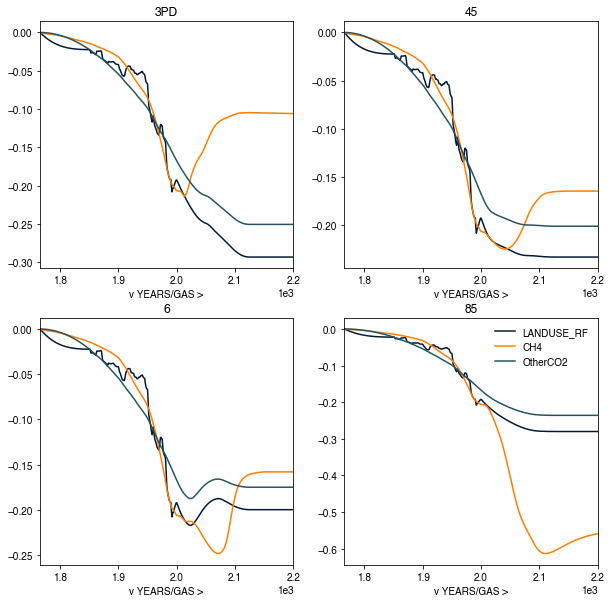

In [21]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
[RCP_data['RF'][RCP]['LANDUSE_RF'].plot(ax=ax.flatten()[i]) for i,RCP in enumerate(RCP_data['RF'].keys())]
[((RCP_data['C'][RCP]['CH4']-720)*-2e-4).plot(ax=ax.flatten()[i]) for i,RCP in enumerate(RCP_data['RF'].keys())]
[(RCP_data['E'][RCP]['OtherCO2'].cumsum()*-1.14e-3).plot(ax=ax.flatten()[i]) for i,RCP in enumerate(RCP_data['RF'].keys())]
plt.legend()
[ax.flatten()[i].set_title(RCP) for i,RCP in enumerate(RCP_data['RF'].keys())]

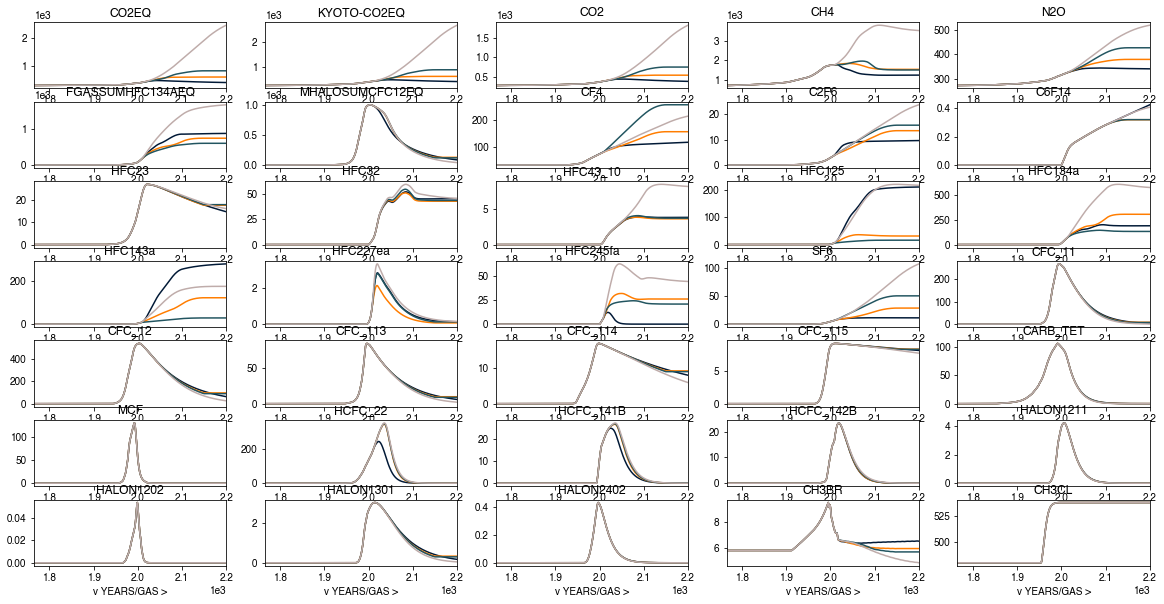

In [22]:
fig,ax = plt.subplots(7,5,figsize=(20,10))
[RCP_data['C'][RCP][species].plot(ax=ax.flatten()[i]) for RCP in RCP_data['C'].keys() for i,species in enumerate(RCP_data['C'][RCP].keys())]
[ax.flatten()[i].set_title(species) for i,species in enumerate(RCP_data['C'][RCP].keys())]
print()

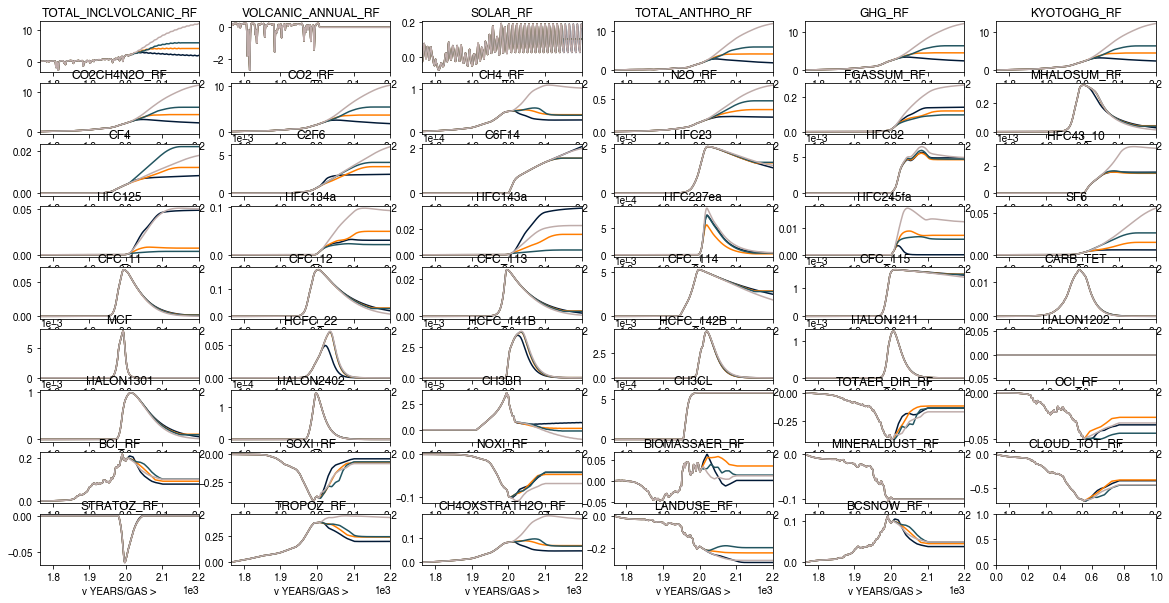

In [23]:
fig,ax = plt.subplots(9,6,figsize=(20,10))
[RCP_data['RF'][RCP][species].plot(ax=ax.flatten()[i]) for RCP in RCP_data['RF'].keys() for i,species in enumerate(RCP_data['RF'][RCP].keys())]
[ax.flatten()[i].set_title(species) for i,species in enumerate(RCP_data['RF'][RCP].keys())]
print()

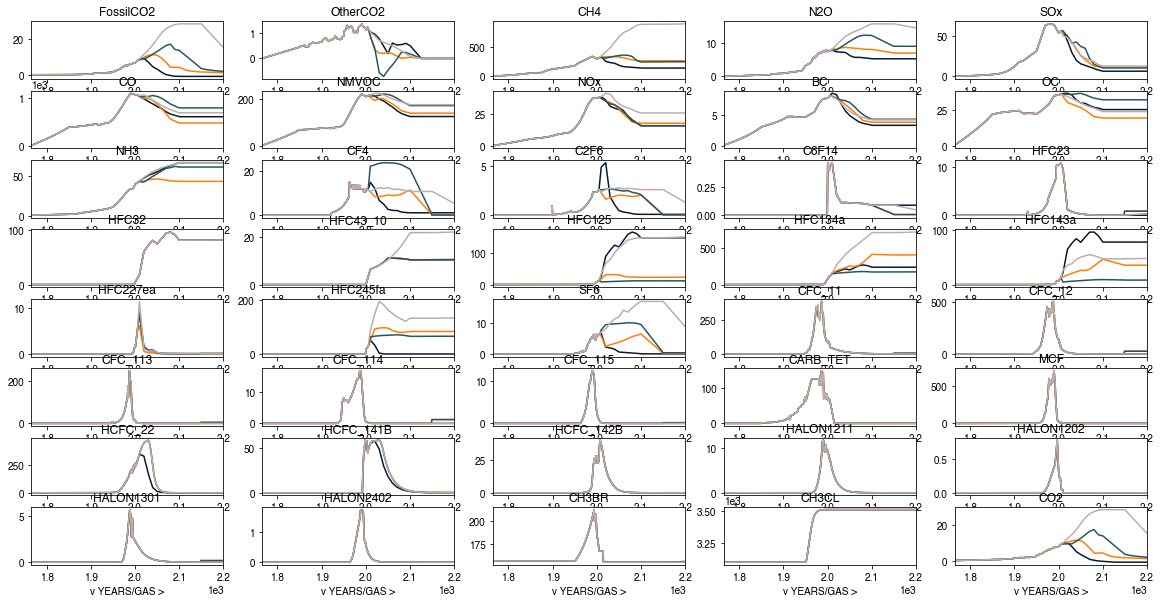

In [24]:
fig,ax = plt.subplots(8,5,figsize=(20,10))
[RCP_data['E'][RCP][species].plot(ax=ax.flatten()[i]) for RCP in RCP_data['E'].keys() for i,species in enumerate(RCP_data['E'][RCP].keys())]
[ax.flatten()[i].set_title(species) for i,species in enumerate(RCP_data['E'][RCP].keys())]
print()